In [229]:
import sys
import torch as t
import torch
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
sys.path.append('/workspace/wilson/Finite-groups/src')
from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from jaxtyping import Float
from typing import Union
from einops import repeat
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
from llc import *
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [407]:
path = '/workspace/models/2024-08-13_17-30-07_Z_97_'
#path = '/workspace/wilson/Finite-groups/models/2024-08-14_00-13-53_Z_97_'
models, params = load_models(path)

In [408]:
data = GroupData(params)

Intersection size: 9409/9409 (1.00)
Added 9409 elements from intersection
Added 0 elements from group 0: Z(97)
Train set size: 9409/9409 (1.00)


In [409]:
model = models[-1][0]

In [410]:
lneurons, rneurons = model.get_neurons()
unem = model.unembedding
lneurons, rneurons, unem = lneurons.squeeze(0), rneurons.squeeze(0), unem.squeeze(0)

In [411]:
p = 97

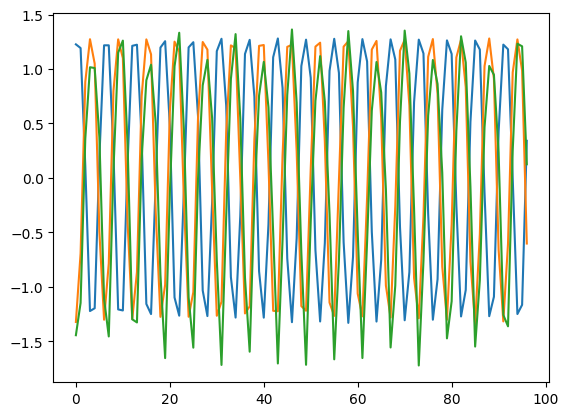

In [412]:
#neur = 1
lneur = lneurons[:,neur] / lfft[:,neur].norm() * p
rneur = rneurons[:,neur] / rfft[:,neur].norm() * p
un = unem[neur,:] / unfft[neur,:].norm() * p
plt.plot(lneur.tolist())
plt.plot(rneur.tolist())
plt.plot(un.flatten().tolist())
plt.show()

In [413]:
rfft[:,0].abs().norm()

tensor(153.7948)

In [414]:
lfft[:,0].norm()**2 / lneurons[:,0].norm()**2

tensor(97.)

In [415]:
lneurons.shape

torch.Size([97, 64])

In [416]:
unem.shape

torch.Size([64, 97])

In [417]:
lfft = torch.fft.fft(lneurons, dim=0)
rfft = torch.fft.fft(rneurons, dim=0)
unfft = torch.fft.fft(unem, dim=1)

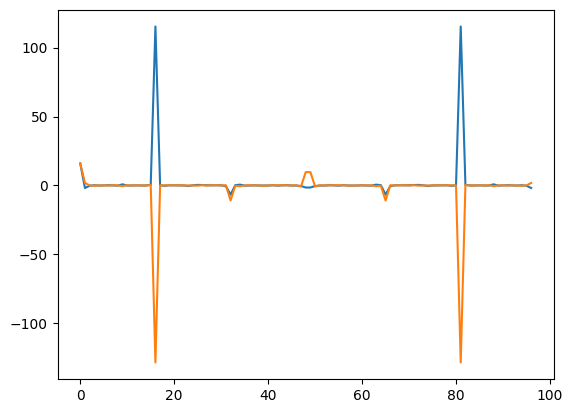

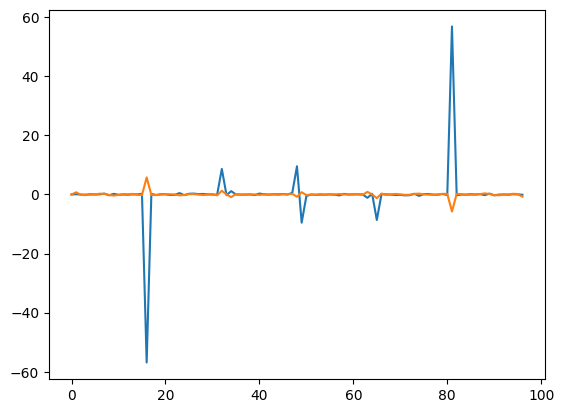

In [418]:
neur=21
p = 97
plt.plot(lfft[:p,neur].real.tolist())
plt.plot(rfft[:p,neur].real.tolist())
plt.show()
plt.plot(lfft[:p,neur].imag.tolist())
plt.plot(rfft[:p,neur].imag.tolist())
#plt.plot(unfft[neur,:].tolist())

In [419]:
def get_top_freq(X, dim=0):
    '''
    Returns (top frequency, phase of top freq, variance explained of top freq, norm) along dim
    '''
    assert X.shape[dim] == p
    X_fft_full = torch.fft.fft(X, dim=0)
    X_fft = X_fft_full.index_select(dim, t.tensor(range(p//2+1)))  # X is assumed real, so symmetry around p//2
    mags, freqs = X_fft.abs().max(dim=dim)
    peak = X_fft.gather(dim=dim, index=freqs.unsqueeze(dim))
    phase = t.atan2(peak.imag, peak.real).squeeze(dim)
    # scale norm by 2/p bc Plancherel theorem(?)
    return freqs, phase, mags**2 / X_fft.norm(dim=dim)**2, X_fft_full.norm(dim=0) / p * np.sqrt(2)
    #return freqs, peak.real / peak.abs(), peak.imag / peak.abs()

In [420]:
lfreqs, lphase, lexpl, lnorm = get_top_freq(lneurons)
rfreqs, rphase, rexpl, rnorm = get_top_freq(rneurons)
ufreqs, uphase, uexpl, unorm = get_top_freq(unem.T)

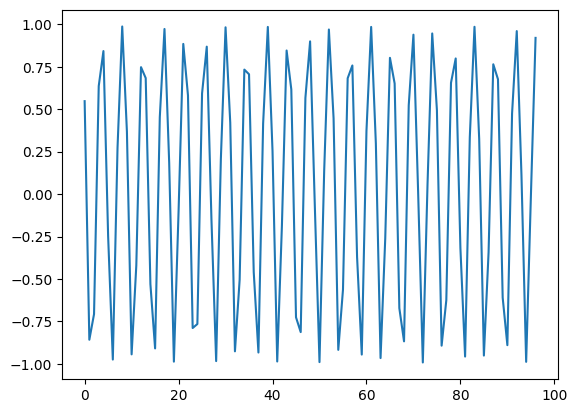

In [421]:
plt.plot(lneurons[:,54] / lnorm[54])

In [422]:
(lneurons[:,1] / lnorm[1]).norm()

tensor(6.9642)

In [423]:
freqs = set(lfreqs.tolist())

In [424]:
freqs

{9, 16, 22, 24, 26, 43}

In [425]:
offsets = {
    freq: ((lphase[lfreqs == freq] - rphase[lfreqs == freq]) % (2*np.pi)).mean().item()
    for freq in freqs
}

In [426]:
offsets

{9: 2.586840867996216,
 43: 6.026066303253174,
 16: 2.727651357650757,
 22: 0.9508991241455078,
 24: 0.8872664570808411,
 26: 2.87091064453125}

In [427]:
wrap = lambda x: (x + np.pi) % (2 * np.pi) - np.pi

r 9 2.586840867996216
g 43 6.026066303253174
b 16 2.727651357650757
m 22 0.9508991241455078
c 24 0.8872664570808411
k 26 2.87091064453125


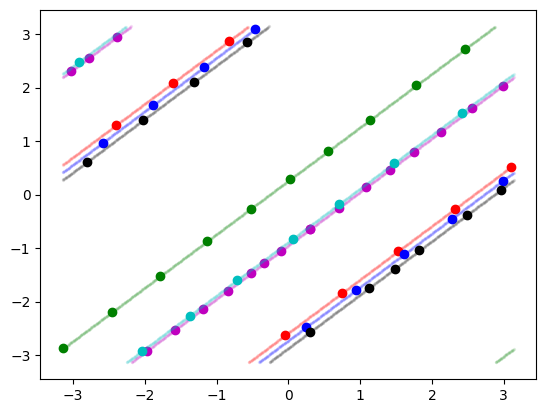

In [428]:
cs = ['r', 'g', 'b', 'm', 'c', 'k']
dom = np.arange(-np.pi, np.pi, 1e-2)
for c, freq in zip(cs, freqs):
    print(c, freq, offsets[freq])
    plt.scatter(lphase[lfreqs == freq].tolist(), rphase[rfreqs == freq].tolist(), c=c)
    plt.scatter(dom, wrap(dom - offsets[freq]), c=c, s=2, alpha=0.1)
plt.show()

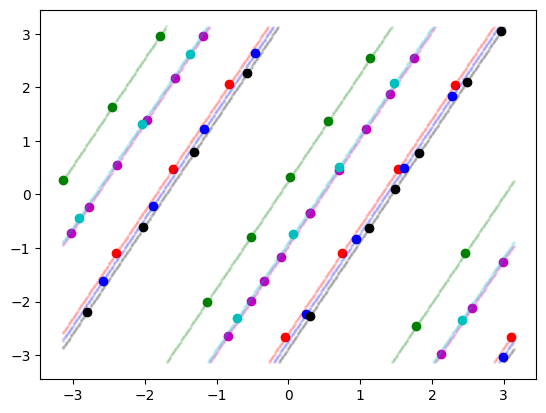

In [429]:
for c, freq in zip(cs, freqs):
    plt.scatter(lphase[lfreqs == freq].tolist(), uphase[rfreqs == freq].tolist(), c=c)
    plt.scatter(dom, wrap(2 * dom - offsets[freq]), c=c, s=2, alpha=0.1)
plt.show()

In [374]:
freq = 22
x = 5
y = 7
z = 12

In [375]:
df = pd.DataFrame(
    data = np.stack([
        lfreqs.numpy(), lneurons[x].numpy(), rneurons[y].numpy(), unem[:,z].detach().numpy(),
        lphase.numpy(), rphase.numpy(), uphase.detach().numpy(),
        lnorm.numpy(), rnorm.numpy(), unorm.detach().numpy(),
    ]).T,
    columns = ['freq', 'lneuron', 'rneuron', 'uneuron', 'lphase', 'rphase', 'uphase', 'lnorm', 'rnorm', 'unorm'],
)

In [382]:
df

,freq,lneuron,rneuron,uneuron,lphase,rphase,uphase,lnorm,rnorm,unorm
0,22.0,-1.804690,1.788374,-0.570932,2.984173,2.032407,-1.266756,2.242473,2.242254,0.418854
1,9.0,-0.366905,-2.897753,0.308090,1.531393,-1.055276,0.475665,3.102700,3.104818,0.598529
2,16.0,-2.450491,-2.332731,0.495380,-1.880083,1.676148,-0.206582,2.693596,2.694235,0.536077
3,24.0,-1.127067,-0.638034,0.389641,0.706087,-0.182441,0.513536,2.505003,2.503225,0.496711
4,16.0,-1.622777,-2.459610,0.261990,-1.168981,2.386918,1.222788,2.705808,2.707499,0.538494
...,...,...,...,...,...,...,...,...,...,...
59,22.0,2.071195,-1.272657,-0.323040,-0.520761,-1.471401,-1.994641,2.224040,2.224195,0.416452
60,24.0,-2.708775,1.619083,-0.105841,1.477818,0.590856,2.075127,2.852347,2.847059,0.580368
61,9.0,2.901917,2.225763,0.416318,-2.397296,1.299998,-1.097514,3.115145,3.116507,0.600588
62,43.0,2.164290,2.178270,0.529709,-1.134660,-0.878074,-2.014802,2.508443,2.512316,0.515148


In [383]:
df_freq = df[(df.freq == 22)].sort_values(by=['lphase'])#.reset_index(drop=True)

In [384]:
df_freq

,freq,lneuron,rneuron,uneuron,lphase,rphase,uphase,lnorm,rnorm,unorm
37,22.0,-0.785400,1.401596,-0.190898,-3.029553,2.301982,-0.727651,1.481667,1.481268,0.277269
7,22.0,-0.521731,2.131892,-0.039043,-2.781850,2.549761,-0.234459,2.168758,2.168140,0.406149
47,22.0,0.561890,2.116390,0.209733,-2.389938,2.942008,0.553416,2.324033,2.322952,0.434849
12,22.0,1.209801,1.642491,0.342601,-1.973603,-2.924492,1.386271,2.313401,2.312469,0.432957
17,22.0,1.617212,1.123885,0.326488,-1.580773,-2.531321,2.169746,2.257805,2.257443,0.422660
45,22.0,2.080473,0.518111,0.191789,-1.187088,-2.137492,2.957363,2.248242,2.248339,0.420810
40,22.0,1.961672,-0.395711,-0.005317,-0.843883,-1.794340,-2.639665,1.987364,1.987597,0.371745
59,22.0,2.071195,-1.272657,-0.323040,-0.520761,-1.471401,-1.994641,2.224040,2.224195,0.416452
51,22.0,0.001589,-0.001531,-0.000452,-0.336147,-1.286874,-1.614941,0.001911,0.001910,0.000349
50,22.0,1.650323,-2.138686,-0.579136,-0.107884,-1.058618,-1.163808,2.362000,2.361274,0.442366


In [435]:
phase_intr = df_freq.lphase[1:].to_numpy() - df_freq.lphase[:-1].to_numpy()

In [436]:
rs = (df_freq.lnorm * df_freq.unorm).to_numpy()

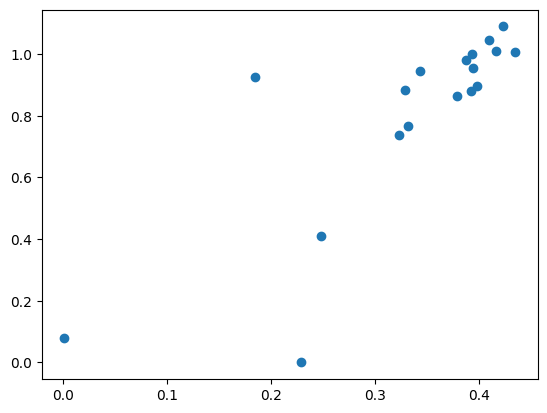

In [439]:
plt.scatter(phase_intr, rs[:-1])

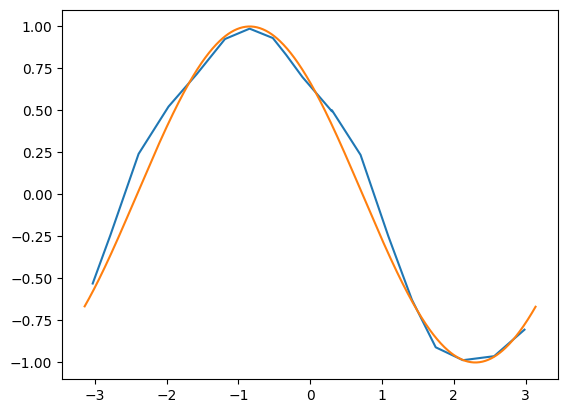

In [379]:
plt.plot(df_freq.lphase, df_freq.lneuron / df_freq.lnorm)
plt.plot(dom, np.cos(x * 2 * np.pi * freq / p + dom))
plt.show()

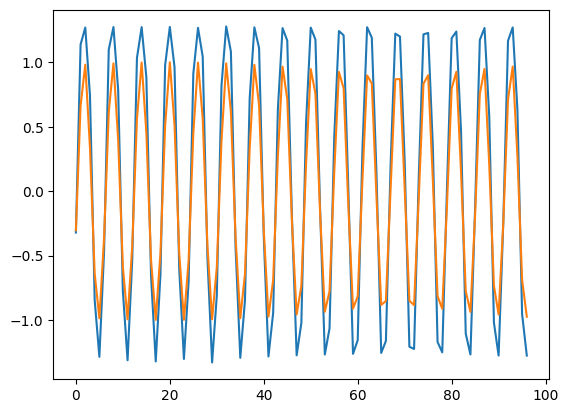

In [318]:
i = 2
plt.plot((lneurons[:,i] / lnorm[i]).tolist())
Zp = np.array(list(range(p)))
plt.plot(Zp, np.cos(Zp * lfreqs[i].item() / p * 2 * np.pi + lphase[i].item() - np.pi))
plt.show()

In [319]:
lphase[2] - np.pi

tensor(-1.8801)

In [298]:
lfreqs

tensor([22,  9, 16, 24, 16, 26, 24, 22, 24,  9,  9, 43, 22, 26, 43, 43, 16, 22,
        22, 43, 26, 16, 22, 16, 16, 26,  9, 24,  9, 16, 26,  9, 26, 22, 26, 43,
        26, 22, 43, 43, 22, 26, 43, 24, 22, 22, 43, 22, 24, 16, 22, 22, 22,  9,
        22, 24, 22, 22, 16, 22, 24,  9, 43, 26])